In [1]:
%config Completer.use_jedi = False

In [78]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
spark = SparkSession.builder.appName("BaseballAnalysis").getOrCreate()

In [6]:
mlb = spark.read.option("header", "true").option("inferSchema", "true").csv("data/players_v2.csv")

In [8]:
mlb_hitting = spark.read.option("header", "true").option("inferSchema", "true").csv("data/hitting.csv")

In [10]:
combined = mlb.join(mlb_hitting, "player_id")

In [72]:
combined.toPandas().columns

Index(['player_id', 'position_txt', 'weight', 'name_display_first_last',
       'college', 'height_inches', 'starter_sw', 'jersey_number', 'end_date',
       'name_first', 'bats', 'team_code', 'height_feet', 'pro_debut_date',
       'status_code', 'primary_position', 'birth_date', 'team_abbrev',
       'throws', 'team_name', 'name_display_last_first', 'name_use',
       'name_last', 'team_id', 'start_date', 'name_full', 'height_in_inches',
       'modified_position', 'bb', 'avg', 'slg', 'ops', 'cs', 'sb', 'hr', 'rbi',
       'lob', 'xbh', 'obp', 'h', 'r', 'ab', 'so', 'babip'],
      dtype='object')

In [12]:
combined.count()

381

In [89]:
visualize_df = (combined
                      .withColumn("position", 
                                  f.when((combined["position_txt"] == "CF") |
                                         (combined["position_txt"] == "LF") |
                                         (combined["position_txt"] == "RF"), "OF")
                                  .otherwise(combined["position_txt"]))
                      .withColumn("bats_mod", 
                                  f.when(combined["bats"] == "R", 0)
                                  .when(combined["bats"] == "L", 1)
                                  .otherwise(2))
                      .withColumn("throws_mod",
                                 f.when(combined["throws"] == "R", 0)
                                 .otherwise(1))
                      .filter((f.col("position").isin(["1B","2B", "3B", "SS", "C", "OF"])) &
                             (f.col("ab") >= 250))
                      .select("position", "weight", "throws_mod", "bats_mod", 'bb', 'avg', 'slg', 'ops', 'cs', 'sb', 'hr', 'rbi',
       'lob', 'xbh', 'obp', 'h', 'r', 'ab', 'so', 'babip', "height_in_inches")
                     )

In [90]:
df = visualize_df.toPandas()

In [91]:
def position_to_int(val):
    if val == "C":
        return 2
    elif val == "1B":
        return 3
    elif val == "2B":
        return 4
    elif val == "3B":
        return 5
    elif val == "SS":
        return 6
    elif val == "OF":
        return 7

In [92]:
df["position_int"] = df.position.apply(position_to_int)

In [93]:
df_mod = df.drop("position", axis=1)

In [97]:
df_mod.head()

,weight,throws_mod,bats_mod,bb,avg,slg,ops,cs,sb,hr,...,lob,xbh,obp,h,r,ab,so,babip,height_in_inches,position_int
0,200,0,0,52,0.254,0.437,0.753,2,8,19,...,239,58,0.316,141,79,556,113,0.280,74,6
1,210,1,1,70,0.232,0.467,0.792,1,4,33,...,245,63,0.325,128,92,552,162,0.265,70,7
2,210,0,2,50,0.269,0.511,0.831,1,5,35,...,265,74,0.320,171,94,636,130,0.283,70,5
3,210,0,0,48,0.245,0.478,0.826,0,0,18,...,141,37,0.348,77,46,314,79,0.271,74,2
4,210,0,2,53,0.329,0.592,0.981,2,10,32,...,192,77,0.389,187,97,569,86,0.342,73,4


In [98]:
coor_matrix = df_mod.corr()

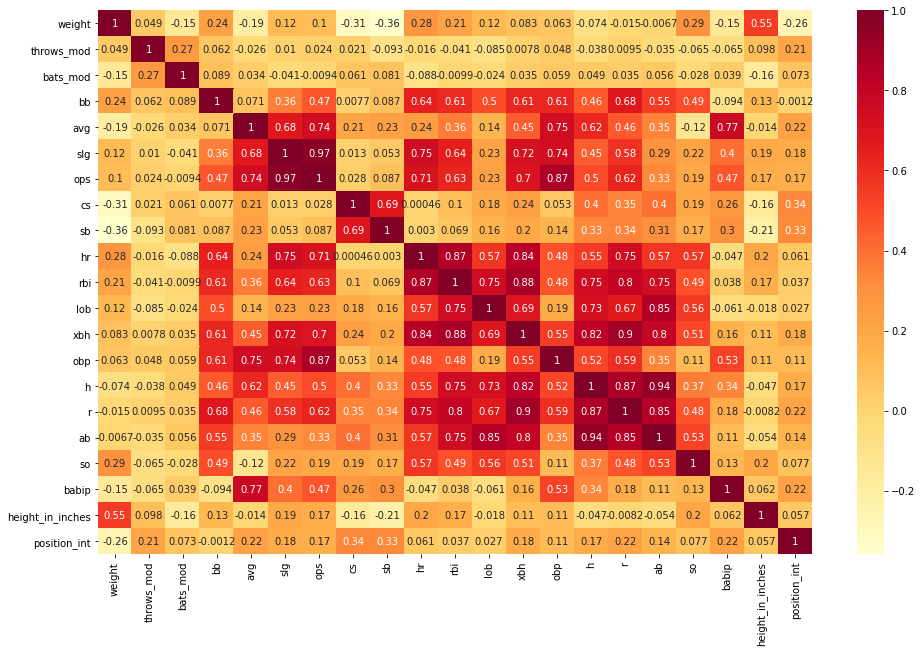

In [103]:
plt.figure(figsize=(16,10))
sns.heatmap(coor_matrix, cmap='YlOrRd', annot=True)
plt.show()

In [38]:
label_and_features = (combined
                      .withColumn("position", 
                                  f.when((combined["position_txt"] == "CF") |
                                         (combined["position_txt"] == "LF") |
                                         (combined["position_txt"] == "RF"), "OF")
                                  .otherwise(combined["position_txt"]))
                      .withColumn("bats_mod", 
                                  f.when(combined["bats"] == "R", 0)
                                  .when(combined["bats"] == "L", 1)
                                  .otherwise(2))
                      .withColumn("throws_mod",
                                 f.when(combined["throws"] == "R", 0)
                                 .otherwise(1))
                      .filter((f.col("position").isin(["1B","2B", "3B", "SS", "C", "OF"])) &
                             (f.col("ab") >= 250))
                      .select("position", "hr", "slg", "bats_mod", "throws_mod", "height_in_inches", "weight")
                     )

In [39]:
label_and_features.toPandas()

,position,hr,slg,bats_mod,throws_mod,height_in_inches,weight
0,SS,19,0.437,0,0,74,200
1,OF,33,0.467,1,1,70,210
2,3B,35,0.511,2,0,70,210
3,C,18,0.478,0,0,74,210
4,2B,32,0.592,2,0,73,210
...,...,...,...,...,...,...,...
216,C,12,0.389,0,0,74,215
217,OF,17,0.419,0,0,72,205
218,OF,38,0.531,1,0,72,225
219,OF,34,0.548,1,1,73,220


In [58]:
label_indexer = StringIndexer(inputCol="position", outputCol="indexedLabel")

In [59]:
vector_assembler = VectorAssembler(inputCols=["hr", "slg", "bats_mod", "throws_mod", "height_in_inches", "weight"], outputCol="features")

In [60]:
feature_indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5)

In [61]:
decision_tree = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

In [62]:
pipeline = Pipeline(stages=[label_indexer, vector_assembler, feature_indexer, decision_tree])

In [63]:
(training_data, test_data) = label_and_features.dropna().randomSplit([0.7,0.3])

In [64]:
test_data.count()

62

In [65]:
model = pipeline.fit(training_data)

In [66]:
predictions = model.transform(test_data)

In [67]:
predictions.select("prediction", "indexedLabel", "features").show(10)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         2.0|[10.0,0.414,1.0,1...|
|       2.0|         2.0|[30.0,0.439,1.0,0...|
|       0.0|         2.0|[34.0,0.476,0.0,0...|
|       0.0|         2.0|[37.0,0.569,2.0,0...|
|       0.0|         2.0|[38.0,0.549,1.0,0...|
|       4.0|         5.0|[2.0,0.321,2.0,0....|
|       4.0|         5.0|[4.0,0.439,1.0,0....|
|       4.0|         5.0|[7.0,0.364,2.0,0....|
|       1.0|         5.0|[16.0,0.486,1.0,0...|
|       5.0|         5.0|[17.0,0.411,0.0,0...|
+----------+------------+--------------------+
only showing top 10 rows



In [68]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

In [69]:
accuracy = evaluator.evaluate(predictions)

In [70]:
print(f"Test Error = {1 - accuracy}")

Test Error = 0.7419354838709677


In [71]:
accuracy

0.25806451612903225